In [1]:
import pandas as pd
import numpy as np

import zipfile 
import os 
import fiona 
import pandas as pd 
import geopandas as gpd 
from pynhd import NHD
import pynhd as nhd
from shapely import MultiPoint, Polygon, MultiPolygon

import matplotlib.pyplot as plt
import seaborn as sns



/Users/kealiepretzlav/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#import 2020 census zip code tabulation areas
zcta = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip')

zcta



,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."
...,...,...,...,...,...,...,...,...,...,...
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.73580 41.33577, -73.73501 41.335..."
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-76.79774 37.21409, -76.79134 37.220..."
33788,23147,23147,B5,G6350,S,143646,0,+37.3696361,-077.0391136,"POLYGON ((-77.04292 37.36996, -77.04143 37.370..."
33789,23298,23298,B5,G6350,S,288664,0,+37.5417074,-077.4295300,"POLYGON ((-77.43285 37.54038, -77.43261 37.540..."


In [3]:
##container for flood potential metric

data_nhd = pd.DataFrame(zcta['ZCTA5CE20'])
data_nhd.columns = ['zcta']
data_nhd

,zcta
0,35592
1,35616
2,35621
3,35651
4,36010
...,...
33786,10540
33787,23081
33788,23147
33789,23298


In [22]:
mr = NHD("flowline_mr")
zcta_ex = zcta.explode()## explode multipolygons
zcta_ex = zcta_ex.reset_index(level=1, drop=True) ## remove multi index 
zcta_ex = zcta_ex.reset_index() ## reset index so no dupes
# for zip_ind in zcta['ZCTA5CE20']: ##loop through zctas
for zip_ind in ['97910']: ##loop through zctas

### this bit of code from https://github.com/hyriver/pynhd
    mr = NHD("flowline_mr") ##medium resolution nhd data
    data_this_zip = zcta_ex.loc[zcta_ex['ZCTA5CE20'] == zip_ind, :]
    
    channel_sum = 0 ##running total of channel length for zip code, takes into account multipolygons
    for n in data_this_zip.index:
        
        try: 
            nhd_zcta = mr.bygeom(data_this_zip.loc[n, :].geometry)
            channel_sum = channel_sum + nhd_zcta['LENGTHKM'].sum()
        except: ##some polys are tiny and have no streamlines
            print('No matched records', zip_ind)
            channel_sum = channel_sum
        
        # print(channel_sum, zip_ind)
    data_nhd.loc[data_nhd['zcta'] == zip_ind, 'channel_length_km'] = channel_sum ## add total channel length to output file


/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_94696/4038078149.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  zcta_ex = zcta.explode()## explode multipolygons


        zcta  channel_length_km
18804  32669              0.011
12843  03854              0.036
16898  55306              0.061
19380  32818              0.083
16409  55122              0.086
...      ...                ...
2448   87825           6914.781
30594  85634           7479.188
3482   59301           7678.538
3490   89049           7972.909
27746  97910           9984.631

[31614 rows x 2 columns]


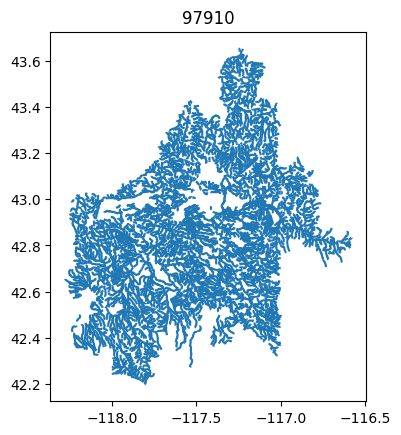

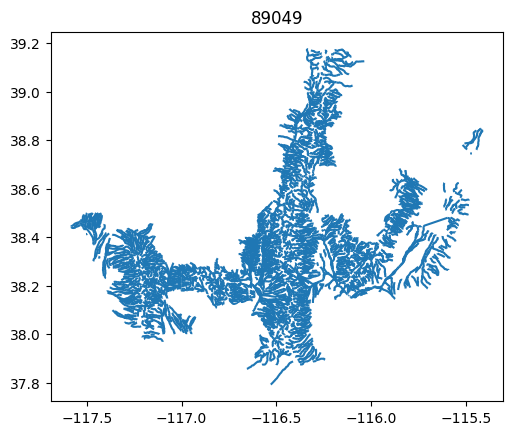

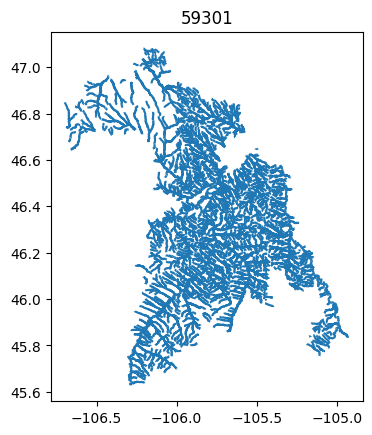

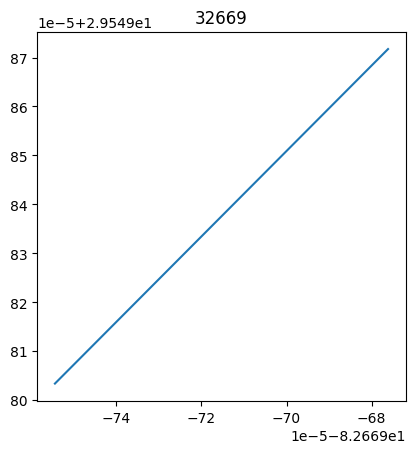

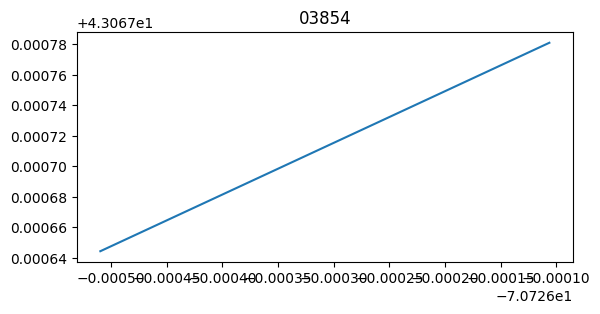

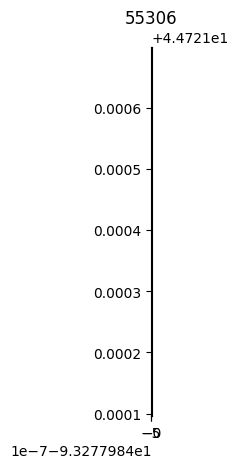

In [65]:
print(data_nhd.loc[data_nhd['channel_length_km'] > 0, :].sort_values('channel_length_km'))

## spot checked outliers (highest and lowest 3 channel length values. Plots for nhd flow lines (medium res) are plotted below.
##I cross-referenced zip code with arcgis online map viewer for each zip to verify shape/line density made sense. 


zips_to_plot = ['97910', '89049', '59301', '32669', '03854', '55306']
for z in zips_to_plot:
    f, ax = plt.subplots(1, 1)
    for n in range(len(zcta_ex.loc[zcta_ex['ZCTA5CE20'] == z, :])):
        mr.bygeom(zcta_ex.loc[zcta_ex['ZCTA5CE20'] == z, :].iloc[n, :].geometry).plot(ax=ax)
        plt.title(z)



In [67]:
data_nhd.to_csv('data/nhd_zip.csv')